In [70]:
import numpy as np
import pandas as pd
from functools import reduce
from datetime import datetime
import os
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt

plt.style.use('ggplot')
#pd.set_option("precision",4)

In [71]:
# df_betas: daily portfolio(P1 to P10, BAB) betas
# df_returns: daily portfolio(P1 to P10, BAB) returns

# US

## Market Data

In [72]:
df_CRSP_market_daily=pd.read_csv('../data/CRSP/CRSP Daily Index Built on Market Capitalization.csv',\
index_col=0,parse_dates=True)

In [73]:
df_CRSP_market_daily =df_CRSP_market_daily[['vwretd']]['2001-01-01':'2020-12-31']

In [74]:
df_AQR_MKT_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='MKT',header=18,index_col=0,parse_dates=True)
df_AQR_MKT_daily= df_AQR_MKT_daily['2001-01-01':'2020-12-31']

In [75]:
df_AQR_risk_free_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='RF',header=18,index_col=0,parse_dates=True)
df_AQR_risk_free_daily= df_AQR_risk_free_daily['2001-01-01':'2020-12-31']

In [76]:
df_FF_5=pd.read_csv('../data/FF_Factors/F-F_Research_Data_5_Factors_2x3_daily.csv',index_col=0,parse_dates=True)
df_FF_5 = df_FF_5['2001-01-01':'2020-12-31']/100

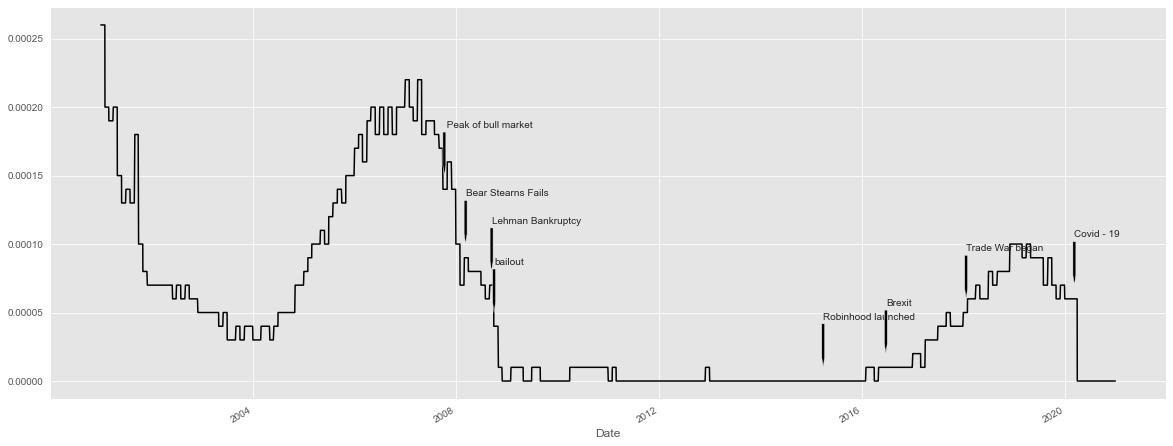

In [77]:
fig, ax = plt.subplots(figsize = (20,8))


df_FF_5.RF.plot(ax = ax, style = 'k-')
crisis_data = [
    (datetime(2007,10,11), ' Peak of bull market'),
    (datetime(2008,3,12), 'Bear Stearns Fails'),
    (datetime(2008,9,15), 'Lehman Bankruptcy'),
    (datetime(2008,10,3), 'bailout'),
    (datetime(2020,3,11), 'Covid - 19'),
    (datetime(2015,3,30), 'Robinhood launched'),
    (datetime(2018,1,22), 'Trade War began'),
    (datetime(2016,6,23), 'Brexit')
]

for date, label in crisis_data:
    ax.annotate(label, xy= (date,df_FF_5.asof(date).RF + 0.00001),
                xytext = (date, df_FF_5.asof(date).RF + 0.00005),
                arrowprops = dict(facecolor = 'black', headwidth = 3, width = 3, headlength = 10),
                horizontalalignment = 'left', verticalalignment = 'top')

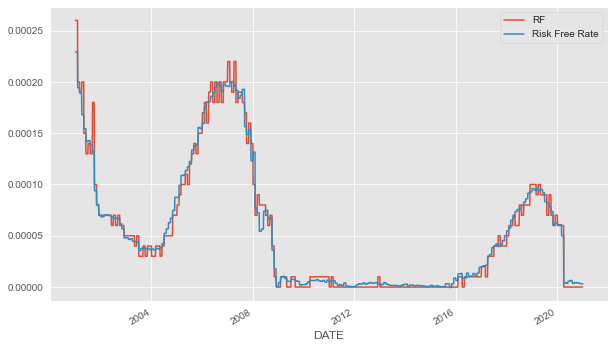

In [78]:
fig, ax =plt.subplots(figsize=(10,6))

df_FF_5.RF.plot(ax=ax)
(df_AQR_risk_free_daily).plot(ax=ax)

plt.legend()

In [79]:
dfs_market_merged=[df_FF_5[['Mkt-RF']],df_CRSP_market_daily[['vwretd']],df_AQR_MKT_daily[['USA']]]
dfs_market_merged=reduce(lambda x,y:pd.merge(x,y,left_index=True, right_index=True),dfs_market_merged)

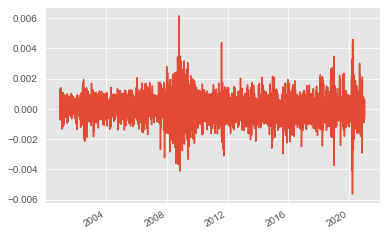

In [80]:
(dfs_market_merged['vwretd']-dfs_market_merged['Mkt-RF']).plot()

In [81]:
dfs_market_merged

,Mkt-RF,vwretd,USA
2001-01-02,-0.0352,-0.034230,-0.034543
2001-01-03,0.0539,0.053170,0.053313
2001-01-04,-0.0130,-0.011674,-0.010935
2001-01-05,-0.0298,-0.028909,-0.028499
2001-01-08,-0.0036,-0.003410,-0.003914
...,...,...,...
2020-12-24,0.0021,0.002332,0.002347
2020-12-28,0.0046,0.003870,0.003893
2020-12-29,-0.0040,-0.003649,-0.003812
2020-12-30,0.0027,0.003281,0.003364


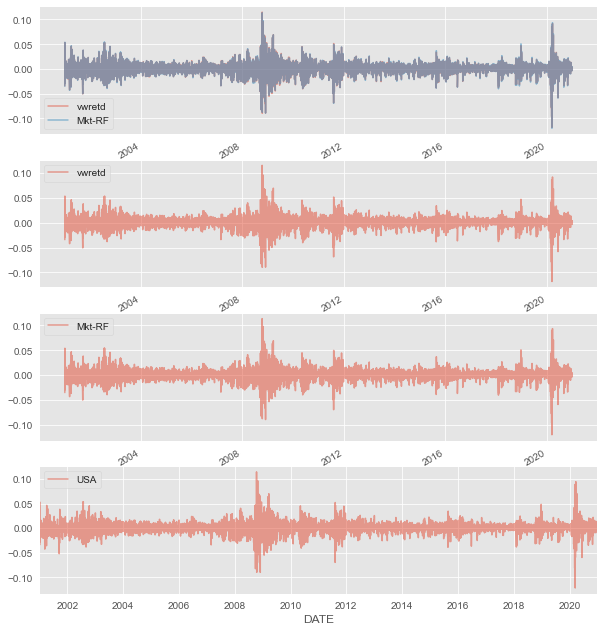

In [82]:
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(10,12))

(df_CRSP_market_daily.vwretd).plot(ax=ax[0],alpha=0.5)
df_FF_5['Mkt-RF'].plot(ax=ax[0],alpha=0.5)

(df_CRSP_market_daily.vwretd).plot(ax=ax[1],alpha=0.5)

df_FF_5['Mkt-RF'].plot(ax=ax[2],alpha=0.5)

df_AQR_MKT_daily['USA'].plot(ax=ax[3],alpha=0.5)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

## Construct the Table 3 and Table 4

In [83]:
def get_alpha(df, factors,portfolio):
    x = df[factors].copy()
    x = sm.add_constant(x)
    results = sm.OLS(df[portfolio], x).fit(cov_type='HC1')
    return results.params[0],results.params[1],results.tvalues[0]

In [84]:
df_betas=pd.read_pickle('../output/US/Portfolio Beta and Return Daily/beta.pickle')
df_returns=pd.read_pickle('../output/US/Portfolio Beta and Return Daily/return.pickle')
df_betas = df_betas.astype('float64')
df_returns = df_returns.astype('float64')

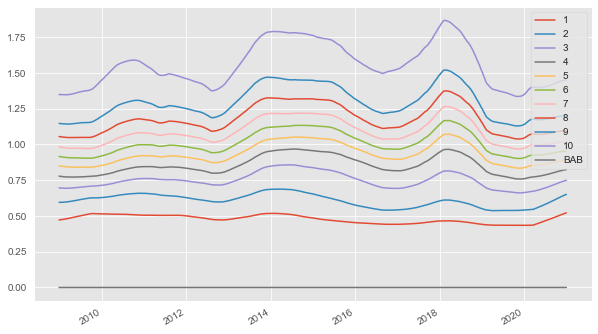

In [85]:
df_betas.rolling(252).mean().plot(figsize=(10,6))

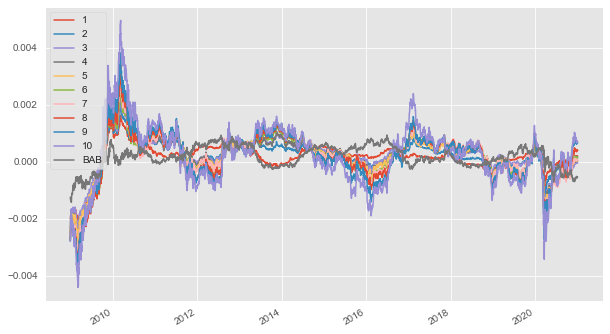

In [86]:
df_returns.rolling(252).mean().plot(figsize=(10,6))

In [87]:
df_Port_FF5=df_returns.merge(df_FF_5,left_index=True,right_index=True)
df_Port_FF5 = df_Port_FF5.dropna()

In [88]:
def get_table_3_4(df,df_beta):
    df_table_3=pd.DataFrame(index=['Excess Return','CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha','Beta(ex ante)','Beta(realized)','Volatility','Sharpe Ratio'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])
    df_table_4=pd.DataFrame(index=['CAPM alpha','Three-factor alpha','Four-factor alpha',
                   'Five-factor alpha'],
            columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','BAB'])
    
    columns = np.concatenate((np.arange(1,11,1), ['BAB'])).astype(str)

    df_table_3.loc[df_table_3.index=='Excess Return',:]=\
    ((((1+df).cumprod().iloc[-1,:11])**(252/len(df))-1)*100).values/12

    df_table_3.loc[df_table_3.index=='CAPM alpha',:]=\
    [(get_alpha(df,['Mkt-RF'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Three-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Four-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML','RMW'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Five-factor alpha',:]=\
    [(get_alpha(df,['Mkt-RF','SMB','HML','RMW','CMA'],i)[0]*22)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Beta(ex ante)',:]=\
    df_beta.mean().values

    df_table_3.loc[df_table_3.index=='Beta(realized)',:]=\
    [get_alpha(df,['Mkt-RF'],i)[1]*0.6+0.4 for i in columns]

    df_table_3.loc[df_table_3.index=='Volatility',:]=\
    [df[i].std()*np.sqrt(252)*100 for i in columns]

    df_table_3.loc[df_table_3.index=='Sharpe Ratio',:]=\
    (df_table_3.loc['Excess Return']*12/df_table_3.loc['Volatility'])[:].values
    
    df_table_4.loc[df_table_4.index=='CAPM alpha',:]=\
    [get_alpha(df,['Mkt-RF'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Three-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Four-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML','RMW'],i)[2] for i in columns]

    df_table_4.loc[df_table_4.index=='Five-factor alpha',:]=\
    [get_alpha(df,['Mkt-RF','SMB','HML','RMW','CMA'],i)[2] for i in columns]

    return df_table_3,df_table_4

In [89]:
df_Port_FF5.index

DatetimeIndex(['2007-12-31', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-07', '2008-01-08', '2008-01-09', '2008-01-10',
               '2008-01-11', '2008-01-14',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=3275, freq=None)

In [90]:
df_Port_FF5.corr()

,1,2,3,4,5,6,7,8,9,10,BAB,Mkt-RF,SMB,HML,RMW,CMA,RF
1,1.000000,0.851652,0.742309,0.679854,0.637380,0.609215,0.593137,0.565121,0.555471,0.547978,0.113427,0.535732,0.135853,0.244015,-0.167546,-0.084087,-0.060306
2,0.851652,1.000000,0.942868,0.904555,0.877532,0.855724,0.841099,0.818107,0.805703,0.783897,-0.184085,0.792196,0.293990,0.340709,-0.260586,-0.099745,-0.062389
3,0.742309,0.942868,1.000000,0.974480,0.958758,0.942233,0.930517,0.912584,0.898776,0.870868,-0.360971,0.896796,0.354122,0.359863,-0.279981,-0.106762,-0.052758
4,0.679854,0.904555,0.974480,1.000000,0.984027,0.973967,0.965250,0.951671,0.938401,0.908820,-0.467292,0.934146,0.392442,0.372029,-0.280061,-0.116405,-0.049563
5,0.637380,0.877532,0.958758,0.984027,1.000000,0.988914,0.984352,0.975329,0.965612,0.939301,-0.552893,0.946773,0.428503,0.402192,-0.285050,-0.123338,-0.043942
6,0.609215,0.855724,0.942233,0.973967,0.988914,1.000000,0.990863,0.985645,0.978041,0.953923,-0.603512,0.949403,0.449496,0.422008,-0.294051,-0.121156,-0.041324
7,0.593137,0.841099,0.930517,0.965250,0.984352,0.990863,1.000000,0.991170,0.986322,0.965499,-0.638657,0.945409,0.467298,0.440691,-0.303947,-0.120206,-0.036679
8,0.565121,0.818107,0.912584,0.951671,0.975329,0.985645,0.991170,1.000000,0.991730,0.975143,-0.679433,0.938326,0.484471,0.464702,-0.308685,-0.114923,-0.034077
9,0.555471,0.805703,0.898776,0.938401,0.965612,0.978041,0.986322,0.991730,1.000000,0.984344,-0.705527,0.929472,0.489630,0.479695,-0.308108,-0.120603,-0.030723
10,0.547978,0.783897,0.870868,0.908820,0.939301,0.953923,0.965499,0.975143,0.984344,1.000000,-0.731096,0.899577,0.489761,0.514424,-0.324894,-0.107407,-0.028133


In [21]:
def plot_cum_return(df, column = None, premium_type = None):
    
    fig, axs = plt.subplots(2,1,figsize = (16,12))
    
    df = df[[column]][df.index.year > 2007]
    
    ((1+df).cumprod()-1).plot(title = 'Cummulative return of risk premium of ' + premium_type, ax = axs[0])
    axs[0].set_xlabel('Year')
    axs[0].set_ylabel('Cummulative return')
    
    df['Year'] = df.index.year
    
    df.groupby('Year')[column].apply(lambda x: (1+x).cumprod().tail(1) - 1).droplevel(1).plot(kind = 'bar')
    axs[1].set_xlabel('Year')
    axs[1].set_ylabel('Annual Return')
    
    
    

In [22]:
def summary_plot(portfolio_summary):
    fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (45,30))
    
    for idx,index in enumerate(portfolio_summary.index):
        
        axs[idx//3,idx%3].bar(portfolio_summary.loc[index].index,portfolio_summary.loc[index], color = 'steelblue')
        props = {
            'title': index,
            'xlabel': 'Portfolio',
            'ylabel': index,
        }
        axs[idx//3,idx%3].set(**props)
        axs[idx//3,idx%3].set_xticklabels(portfolio_summary.columns)
        axs[idx//3,idx%3].tick_params(axis='both', which='major', labelsize=15)
        
   

In [23]:
temp = df_FF_5.copy()
df_FF_5_monthly = temp.groupby(pd.Grouper(freq="M")).apply(lambda x: ((1+x).cumprod()-1).tail(1)).droplevel(1)

In [24]:
temp = df_returns.copy()
df_returns_monthly = temp.groupby(pd.Grouper(freq="M")).apply(lambda x: ((1+x).cumprod()-1).tail(1)).droplevel(1)

In [25]:
def factors_loading(df_quantiles,df_factors):
    fig, axs = plt.subplots(4,3, figsize = (30,40),sharey = True)
    
    
    model_data = df_quantiles.merge(df_factors, left_index = True, right_index = True)
    model_data.columns = ['P' + str(i) for i in range(1,11)] + ['BAB'] + ['MKT','SMB','HML','RMW','CMA']
    
    for idx, column in enumerate(['P' + str(i) for i in range(1,11)] + ['BAB']):
        data = model_data[[column,'MKT','SMB','HML','RMW','CMA']].copy()
        data['const'] = 1

        #fit
        model = RollingOLS(endog =data[column].values , exog = data[['const','MKT','SMB','HML','RMW','CMA']],window=625)
        rres = model.fit()
        
        rres.params.iloc[:,1:].plot(ax = axs[idx//3,idx%3])
        axs[idx//3,idx%3].set_title(column + ' Rolling beta')
        axs[idx//3,idx%3].set_xlabel('Year', fontsize=18)
        axs[idx//3,idx%3].set_ylabel('Beta', fontsize=18)
        axs[idx//3,idx%3].tick_params(axis='both', which='major', labelsize=15)


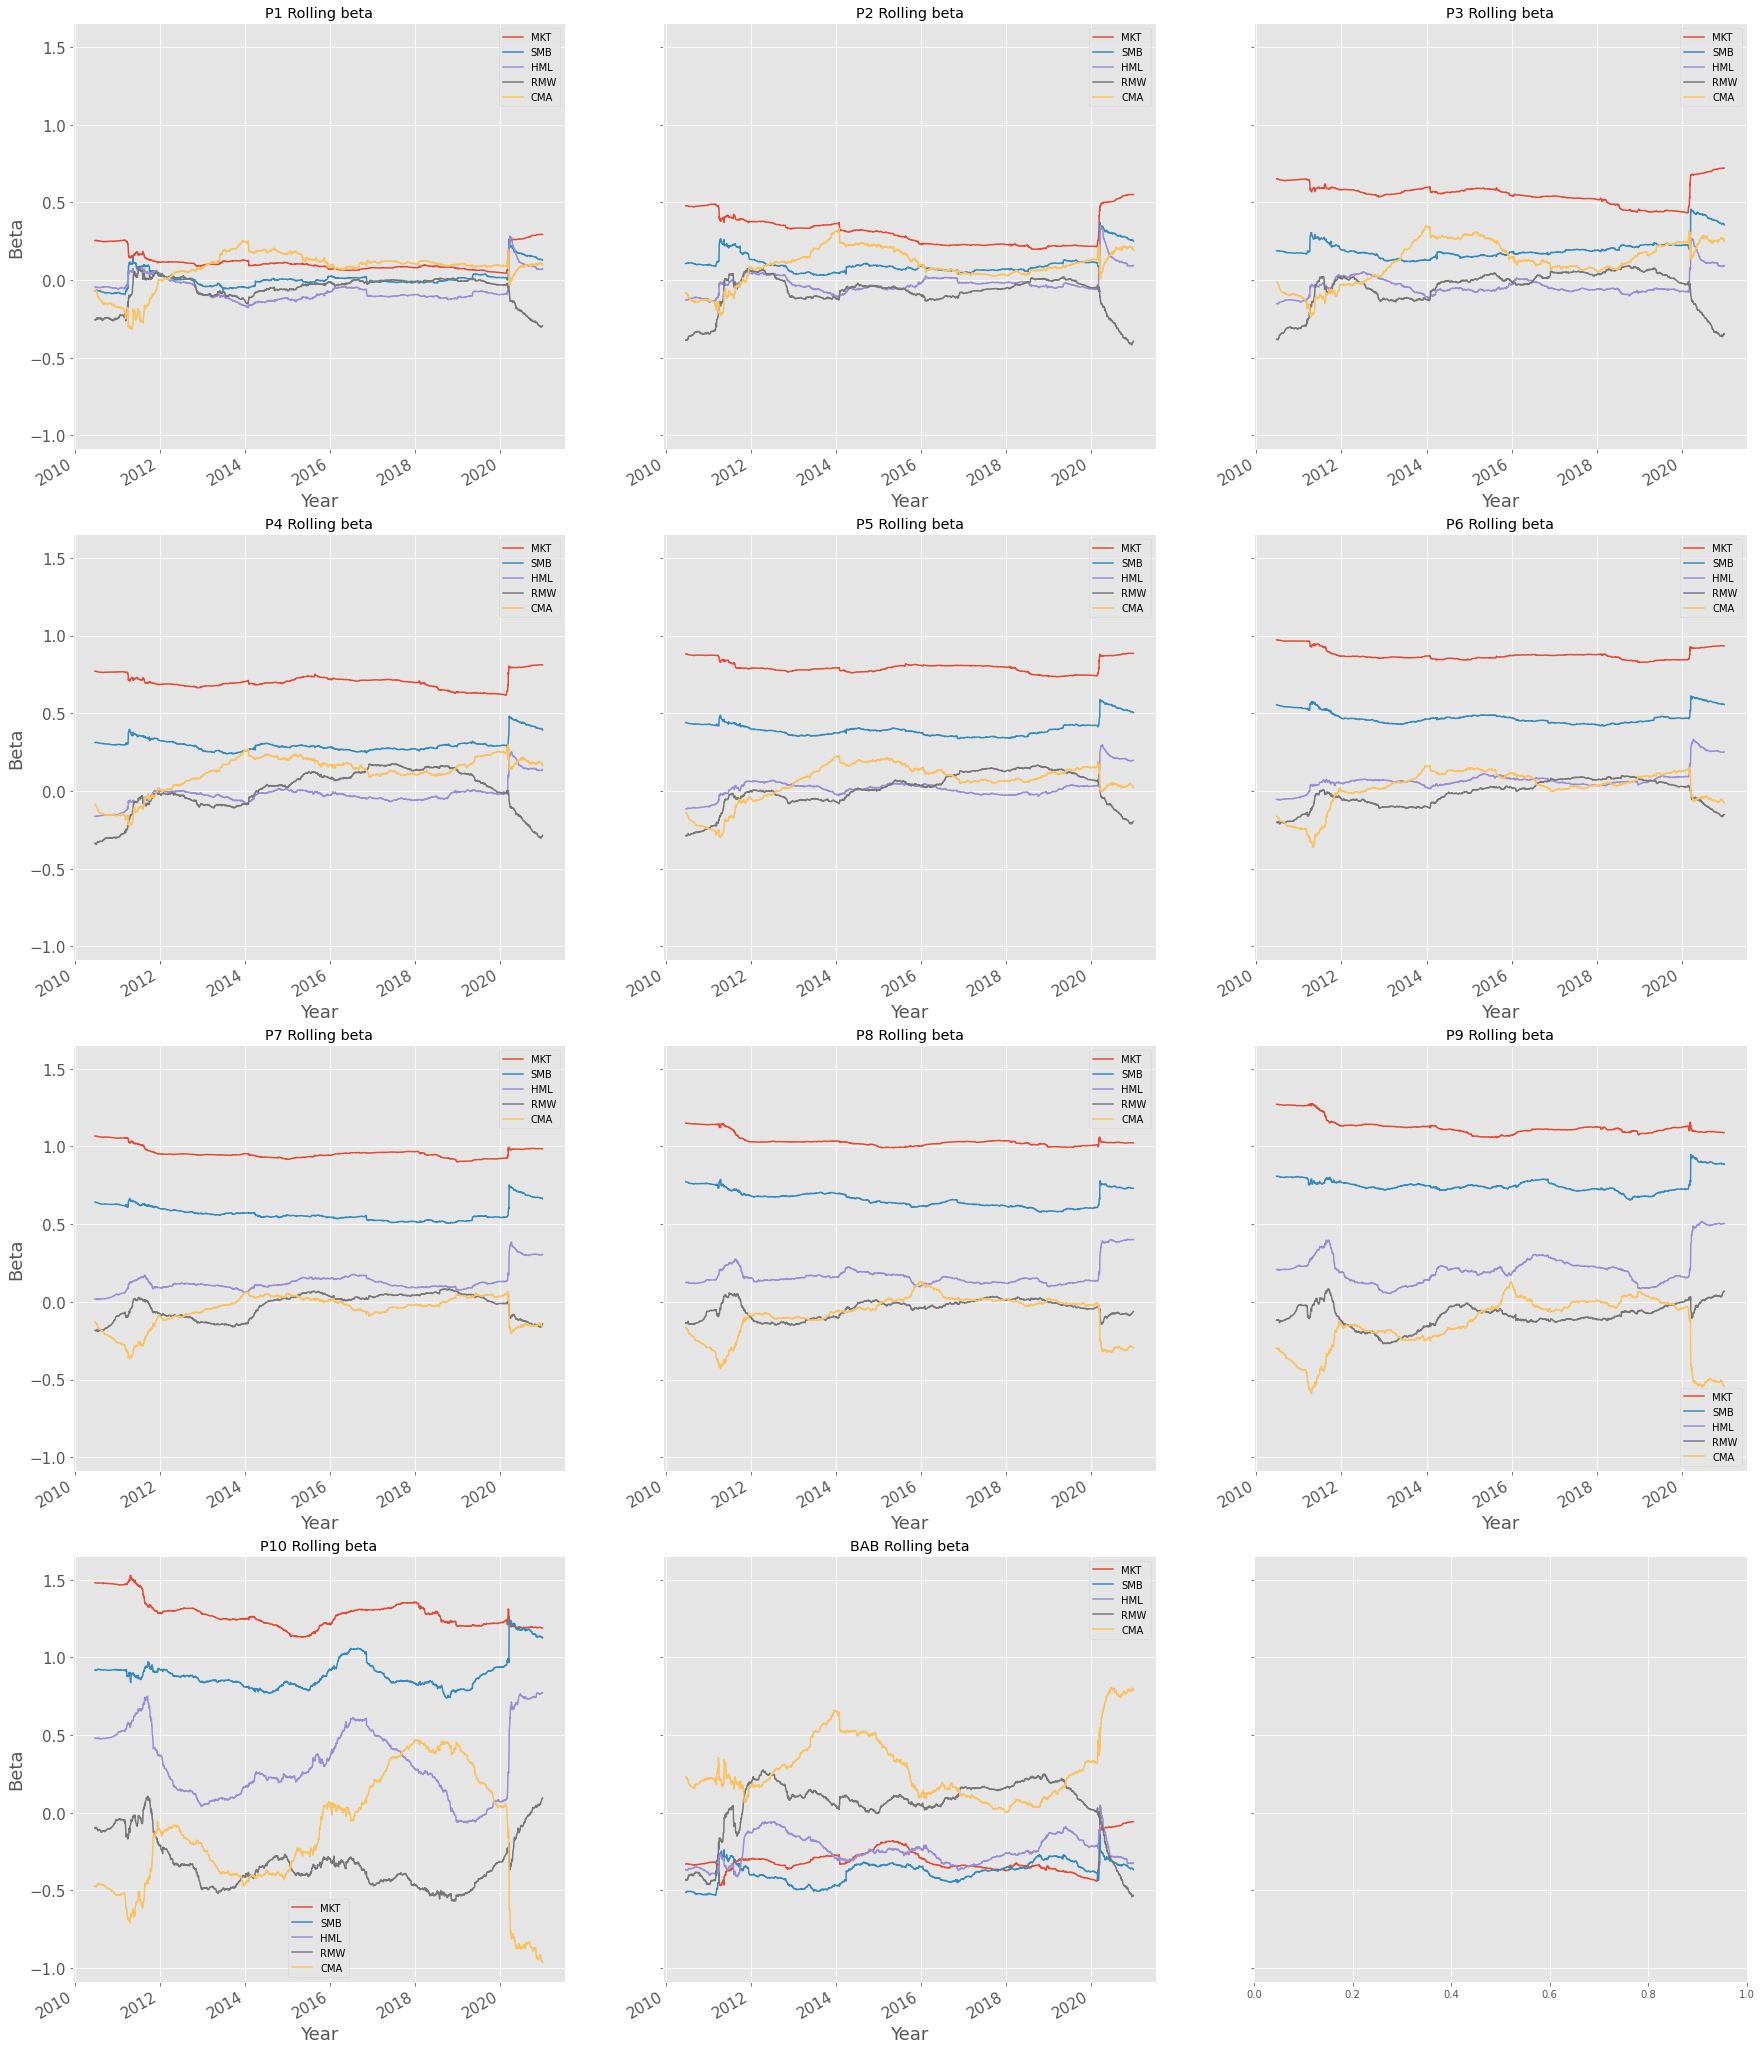

In [26]:
factors_loading(df_returns,df_FF_5.drop('RF',axis = 1))
plt.savefig('../output/US/Graphs/portfolios rolling beta.jpg')

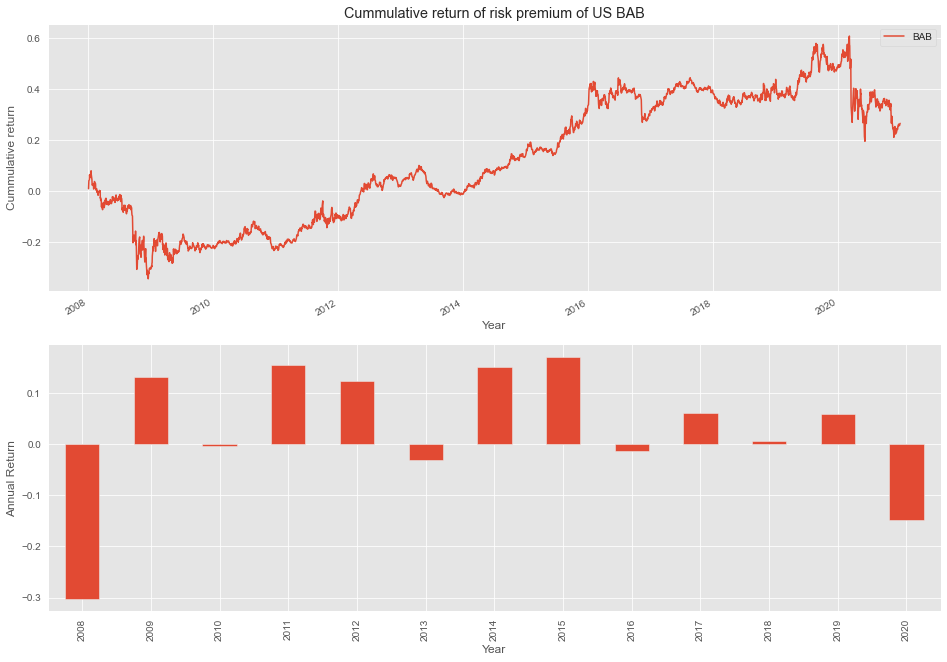

In [91]:
plot_cum_return(df_returns[['BAB']], column = 'BAB', premium_type = 'US BAB')
plt.savefig('../output/US/Graphs/cumulative excess returns factors/bab.jpg', dpi = 150)

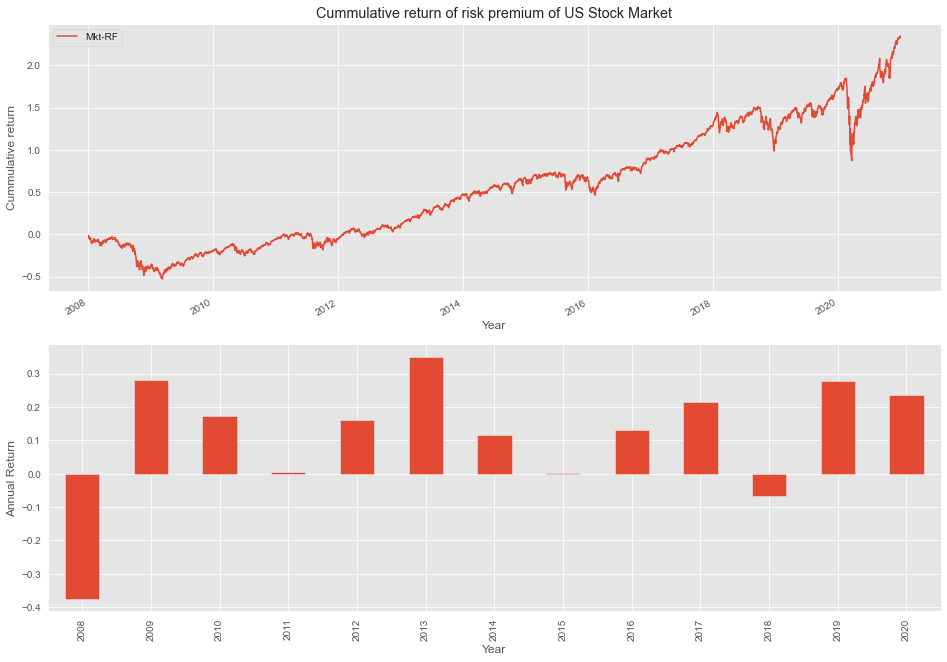

In [92]:
plot_cum_return(df_FF_5[df_FF_5.index.year<2021],column = 'Mkt-RF', premium_type = 'US Stock Market')
plt.savefig('../output/US/Graphs/cumulative excess returns factors/mkt.jpg', dpi = 150)

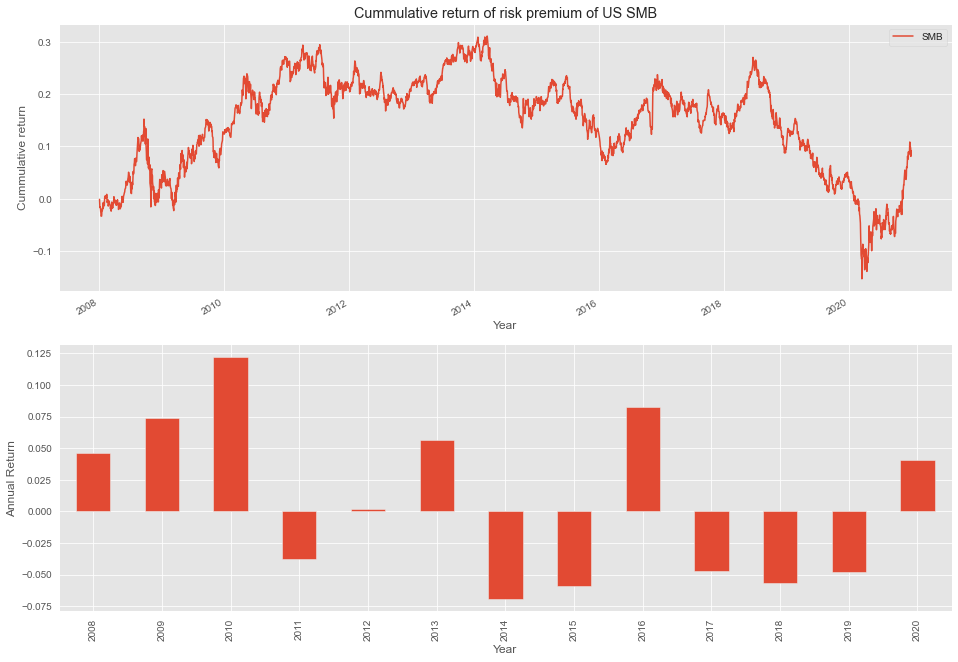

In [93]:
plot_cum_return(df_FF_5[df_FF_5.index.year<2021],column = 'SMB', premium_type = 'US SMB')
plt.savefig('../output/US/Graphs/cumulative excess returns factors/smb.jpg', dpi = 150)

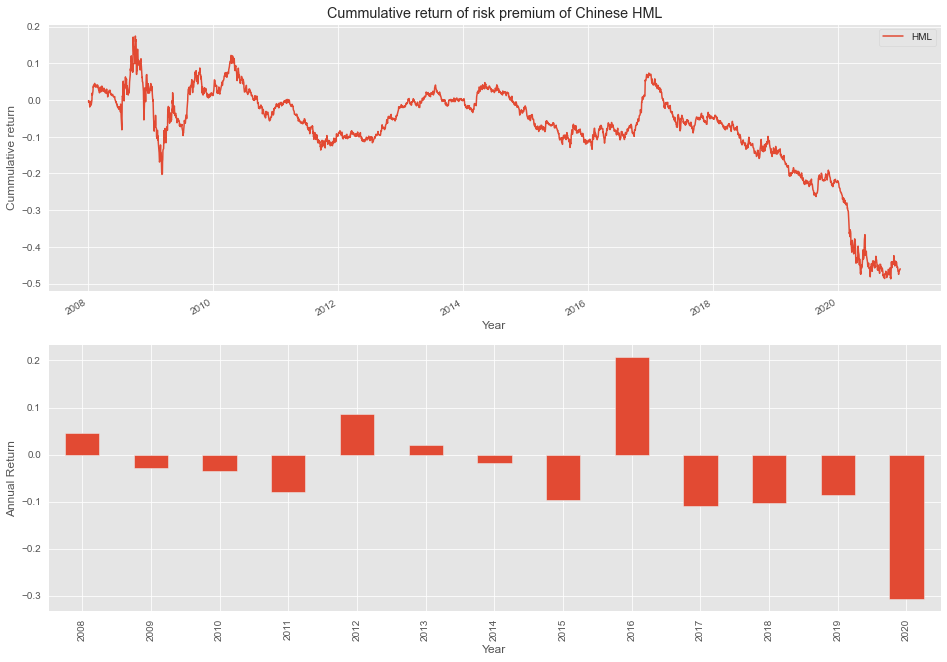

In [94]:
plot_cum_return(df_FF_5[df_FF_5.index.year<2021],column = 'HML', premium_type = 'Chinese HML')
plt.savefig('../output/US/Graphs/cumulative excess returns factors/HML.jpg', dpi = 150)

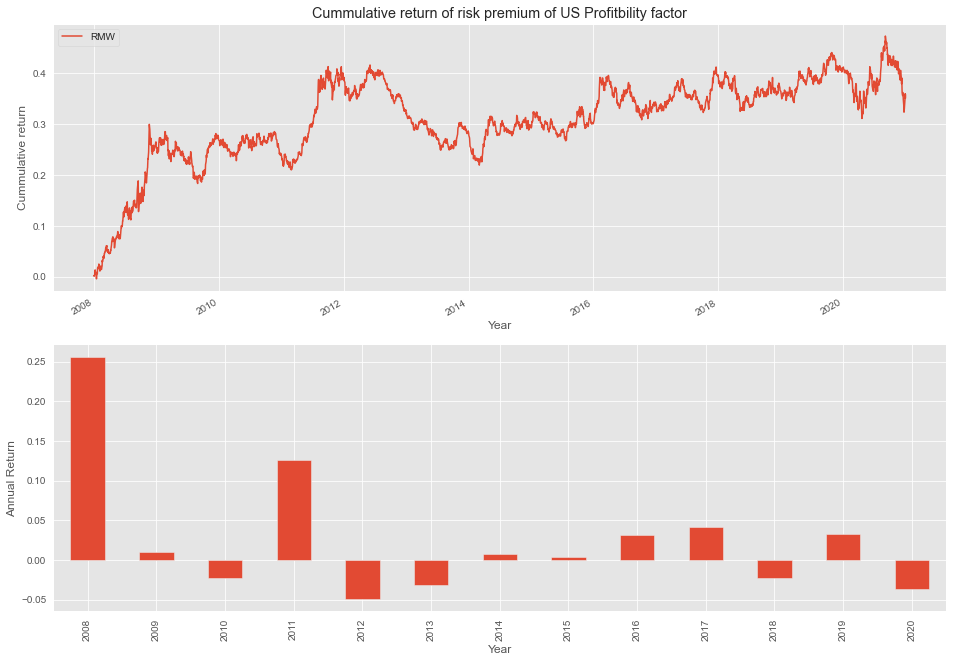

In [96]:
plot_cum_return(df_FF_5[df_FF_5.index.year<2021],column = 'RMW', premium_type = 'US Profitbility factor')
plt.savefig('../output/US/Graphs/cumulative excess returns factors/rmw.jpg', dpi = 150)

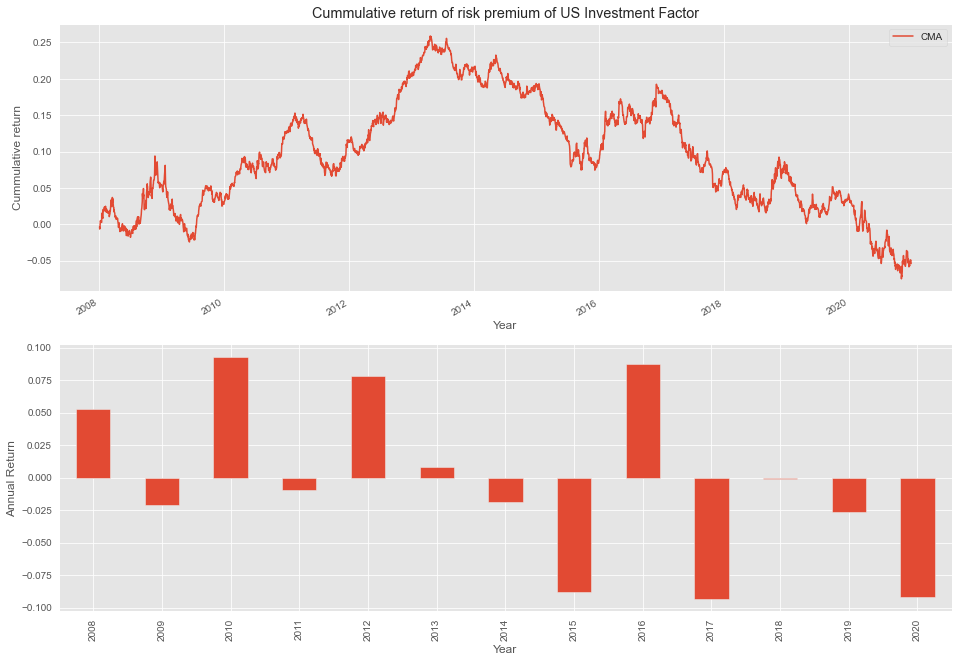

In [95]:
plot_cum_return(df_FF_5[df_FF_5.index.year<2021],column = 'CMA', premium_type = 'US Investment Factor')
plt.savefig('../output/US/Graphs/cumulative excess returns factors/cma.jpg', dpi = 150)

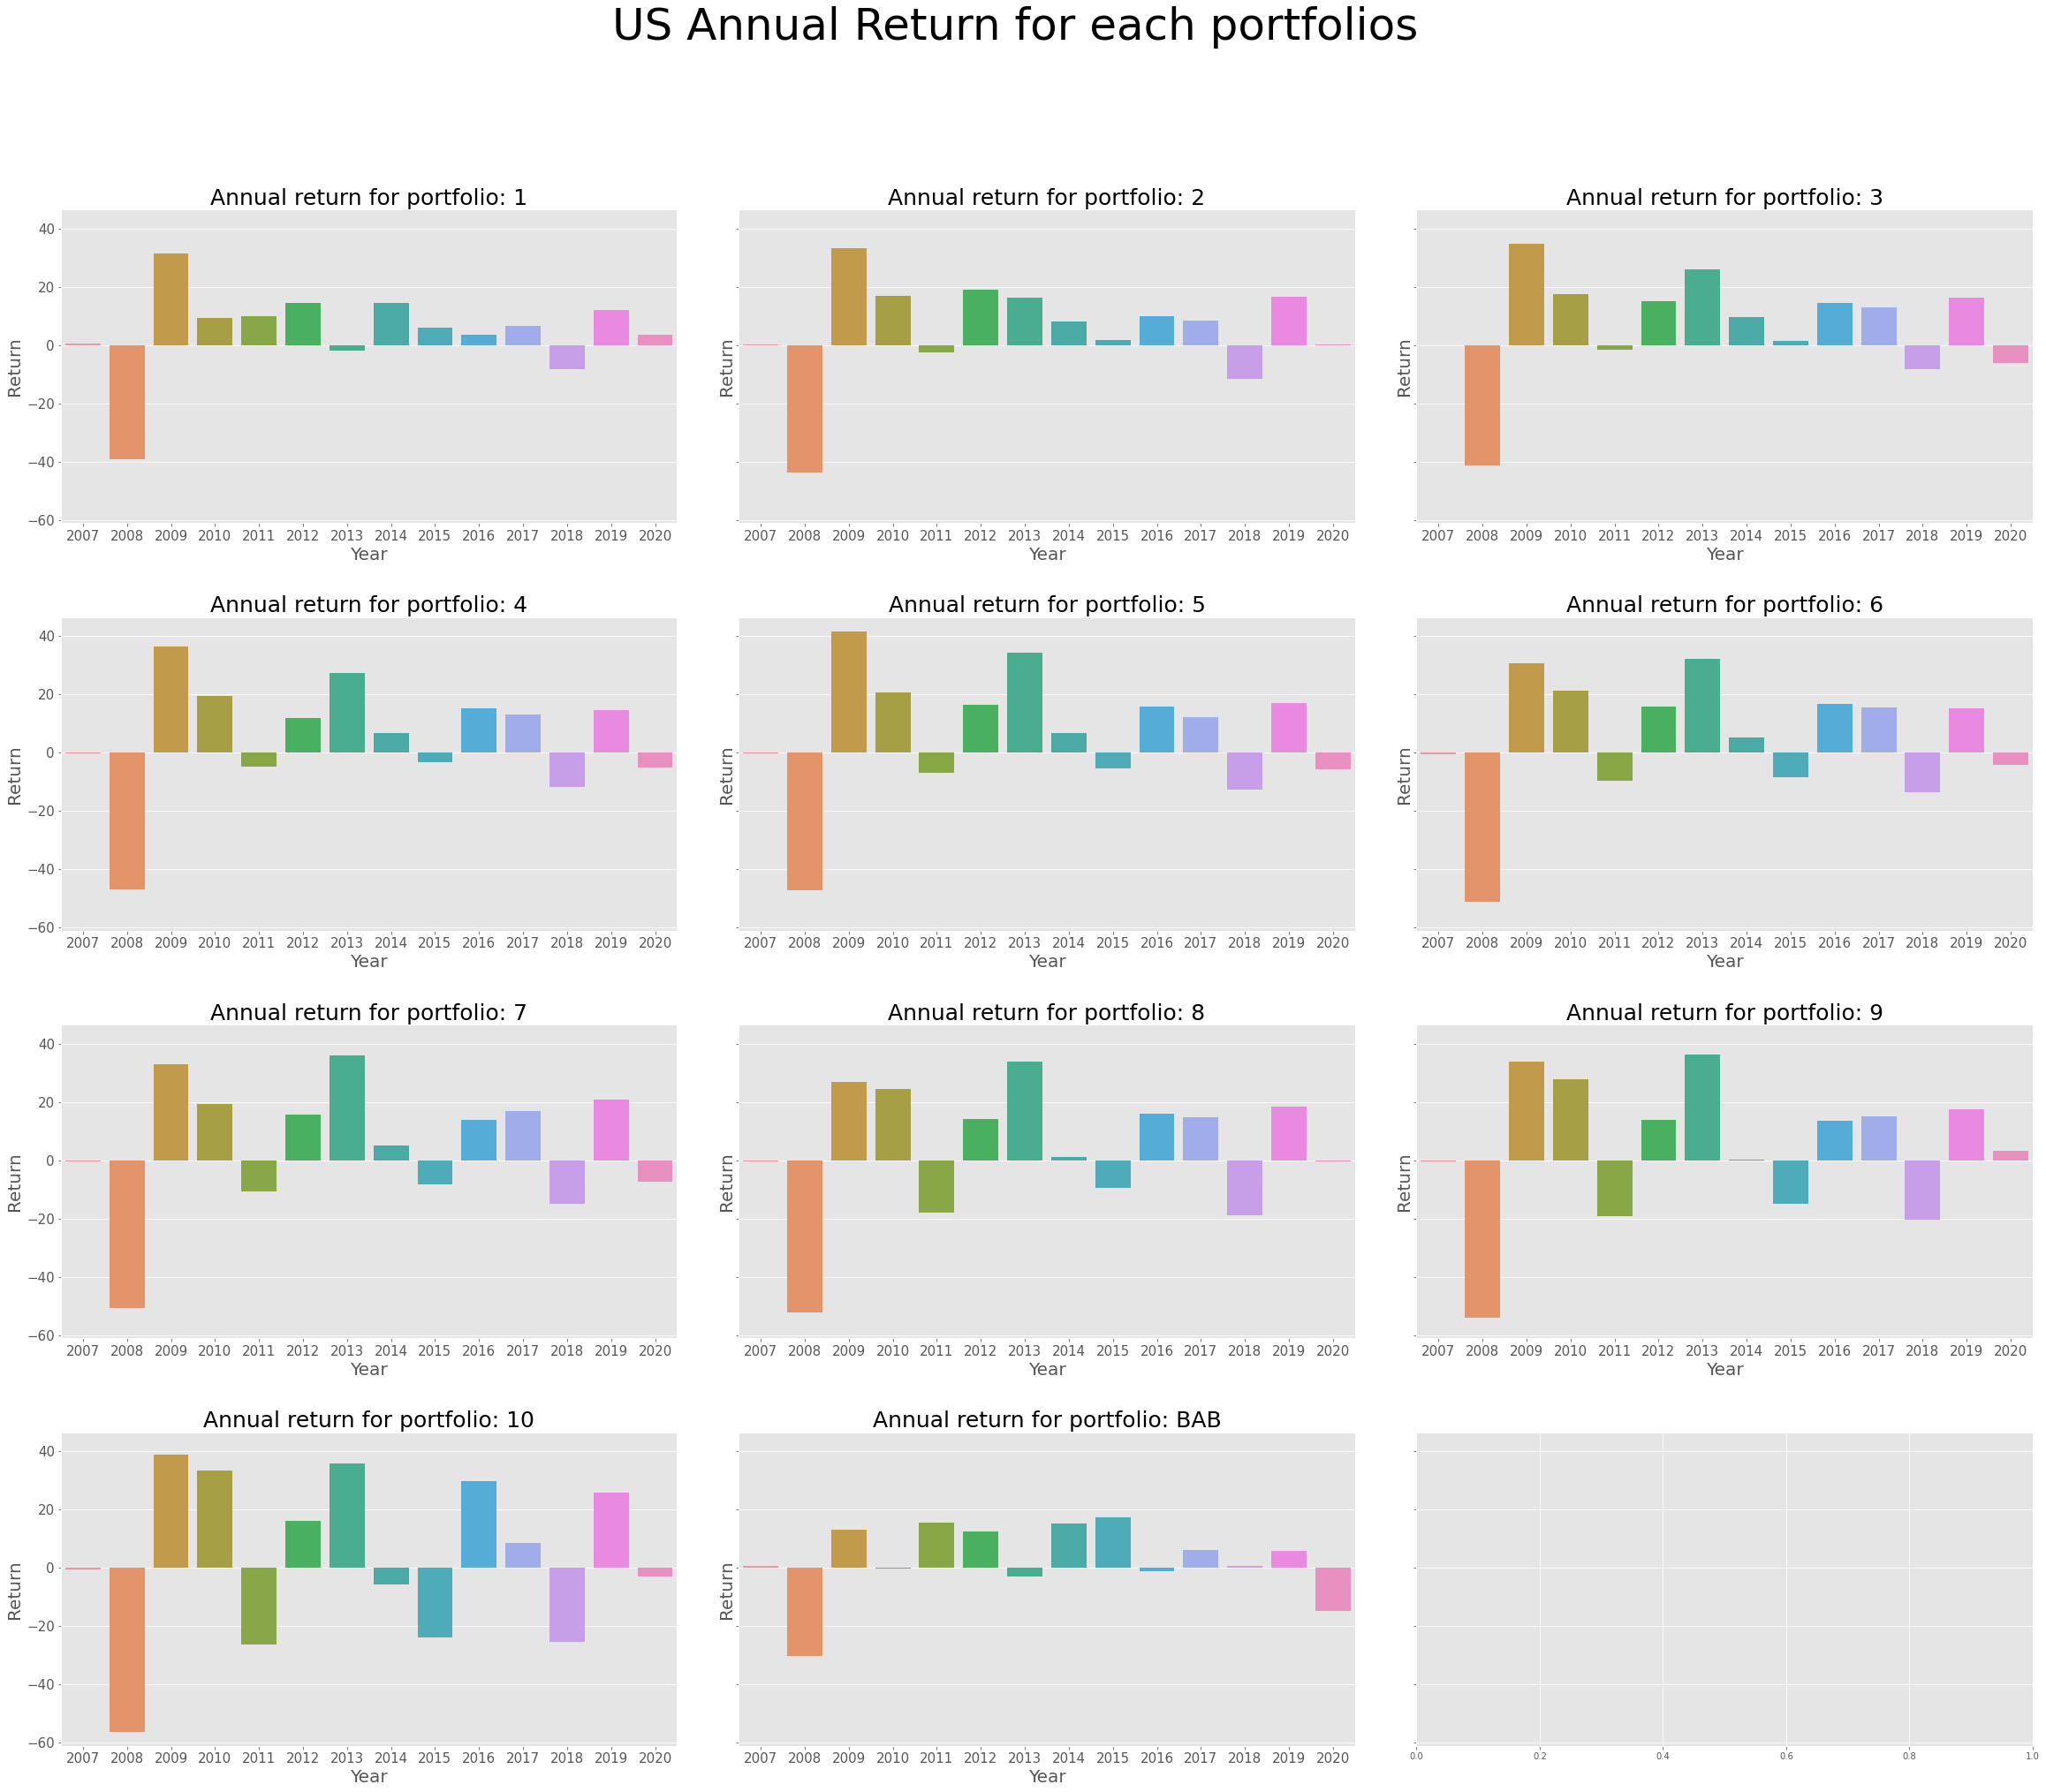

In [33]:
fig, axs = plt.subplots(4,3,figsize = (40,32), sharey = True)

fig.suptitle('US Annual Return for each portfolios', fontsize = 50)
for idx,portfolio in enumerate(df_returns.columns):
    portfolio_yearly = pd.DataFrame(df_returns[portfolio])
    portfolio_yearly.index.name = 'Date'
    portfolio_yearly.columns = ['return']
    portfolio_yearly['Year'] = portfolio_yearly.index.year
    portfolio_yearly = portfolio_yearly.groupby('Year')['return'].apply(lambda x: (1+x).cumprod().iloc[-1] - 1)
    portfolio_yearly = pd.DataFrame(portfolio_yearly * 100)
    portfolio_yearly = portfolio_yearly.reset_index()
    sns.barplot(x = 'Year', y = 'return', data = portfolio_yearly, ci = False, ax = axs[idx//3,idx%3])
    axs[idx//3,idx%3].set_title('Annual return for portfolio: ' + portfolio, fontsize=25)
    axs[idx//3,idx%3].set_xlabel('Year', fontsize = 20)
    axs[idx//3,idx%3].set_ylabel('Return', fontsize = 20)
    axs[idx//3,idx%3].tick_params(axis='both', which='major', labelsize=15)


plt.subplots_adjust(wspace = 0.1, hspace = 0.3)

fig.savefig("../output/US/Graphs/US Annual Return for each portfolio.jpg", bbox_inches='tight')    

### All data: 2008-2020

In [34]:
start='2008-01-01'
end = '2020-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [35]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.279424,0.305684,0.423402,0.269563,0.329263,0.185262,0.189931,0.0600736,0.0396385,-0.0897743,0.152649
CAPM alpha,0.10157,-0.0738014,-0.115881,-0.368155,-0.387966,-0.593558,-0.644955,-0.825569,-0.896584,-1.07665,0.629181
Three-factor alpha,0.127762,-0.0396989,-0.0883894,-0.340633,-0.336145,-0.519059,-0.541378,-0.680217,-0.708703,-0.766847,0.494107
Four-factor alpha,0.132249,-0.0298668,-0.0865887,-0.351641,-0.354216,-0.534837,-0.55062,-0.687838,-0.718141,-0.739656,0.508099
Five-factor alpha,0.136189,-0.029741,-0.091021,-0.355123,-0.351915,-0.530253,-0.542074,-0.674954,-0.695017,-0.705421,0.484484
Beta(ex ante),0.479212,0.609509,0.747277,0.849948,0.929285,1.00369,1.08158,1.16905,1.28325,1.54483,0
Beta(realized),0.530464,0.669173,0.787844,0.865922,0.937739,0.996547,1.06076,1.12244,1.20154,1.35044,0.170432
Volatility,8.61305,12.0215,15.3019,17.6474,20.096,22.232,24.7289,27.2414,30.5121,37.3824,13.8705
Sharpe Ratio,0.389304,0.305137,0.33204,0.1833,0.196614,0.0999975,0.092166,0.0264628,0.0155893,-0.0288181,0.132063


In [36]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,0.549236,-0.392405,-0.671029,-2.32151,-2.4167,-3.4763,-3.28331,-3.63836,-3.30662,-2.74289,2.25175
Three-factor alpha,0.704319,-0.221204,-0.555311,-2.51059,-2.90846,-4.97186,-5.05795,-6.03788,-5.00523,-3.17403,2.02077
Four-factor alpha,0.714678,-0.163183,-0.533895,-2.5515,-3.02452,-5.08607,-5.06053,-6.075,-5.03011,-3.0388,2.04616
Five-factor alpha,0.736019,-0.162846,-0.56234,-2.57648,-3.00962,-5.05348,-5.00741,-6.0303,-4.97987,-2.94818,1.96761


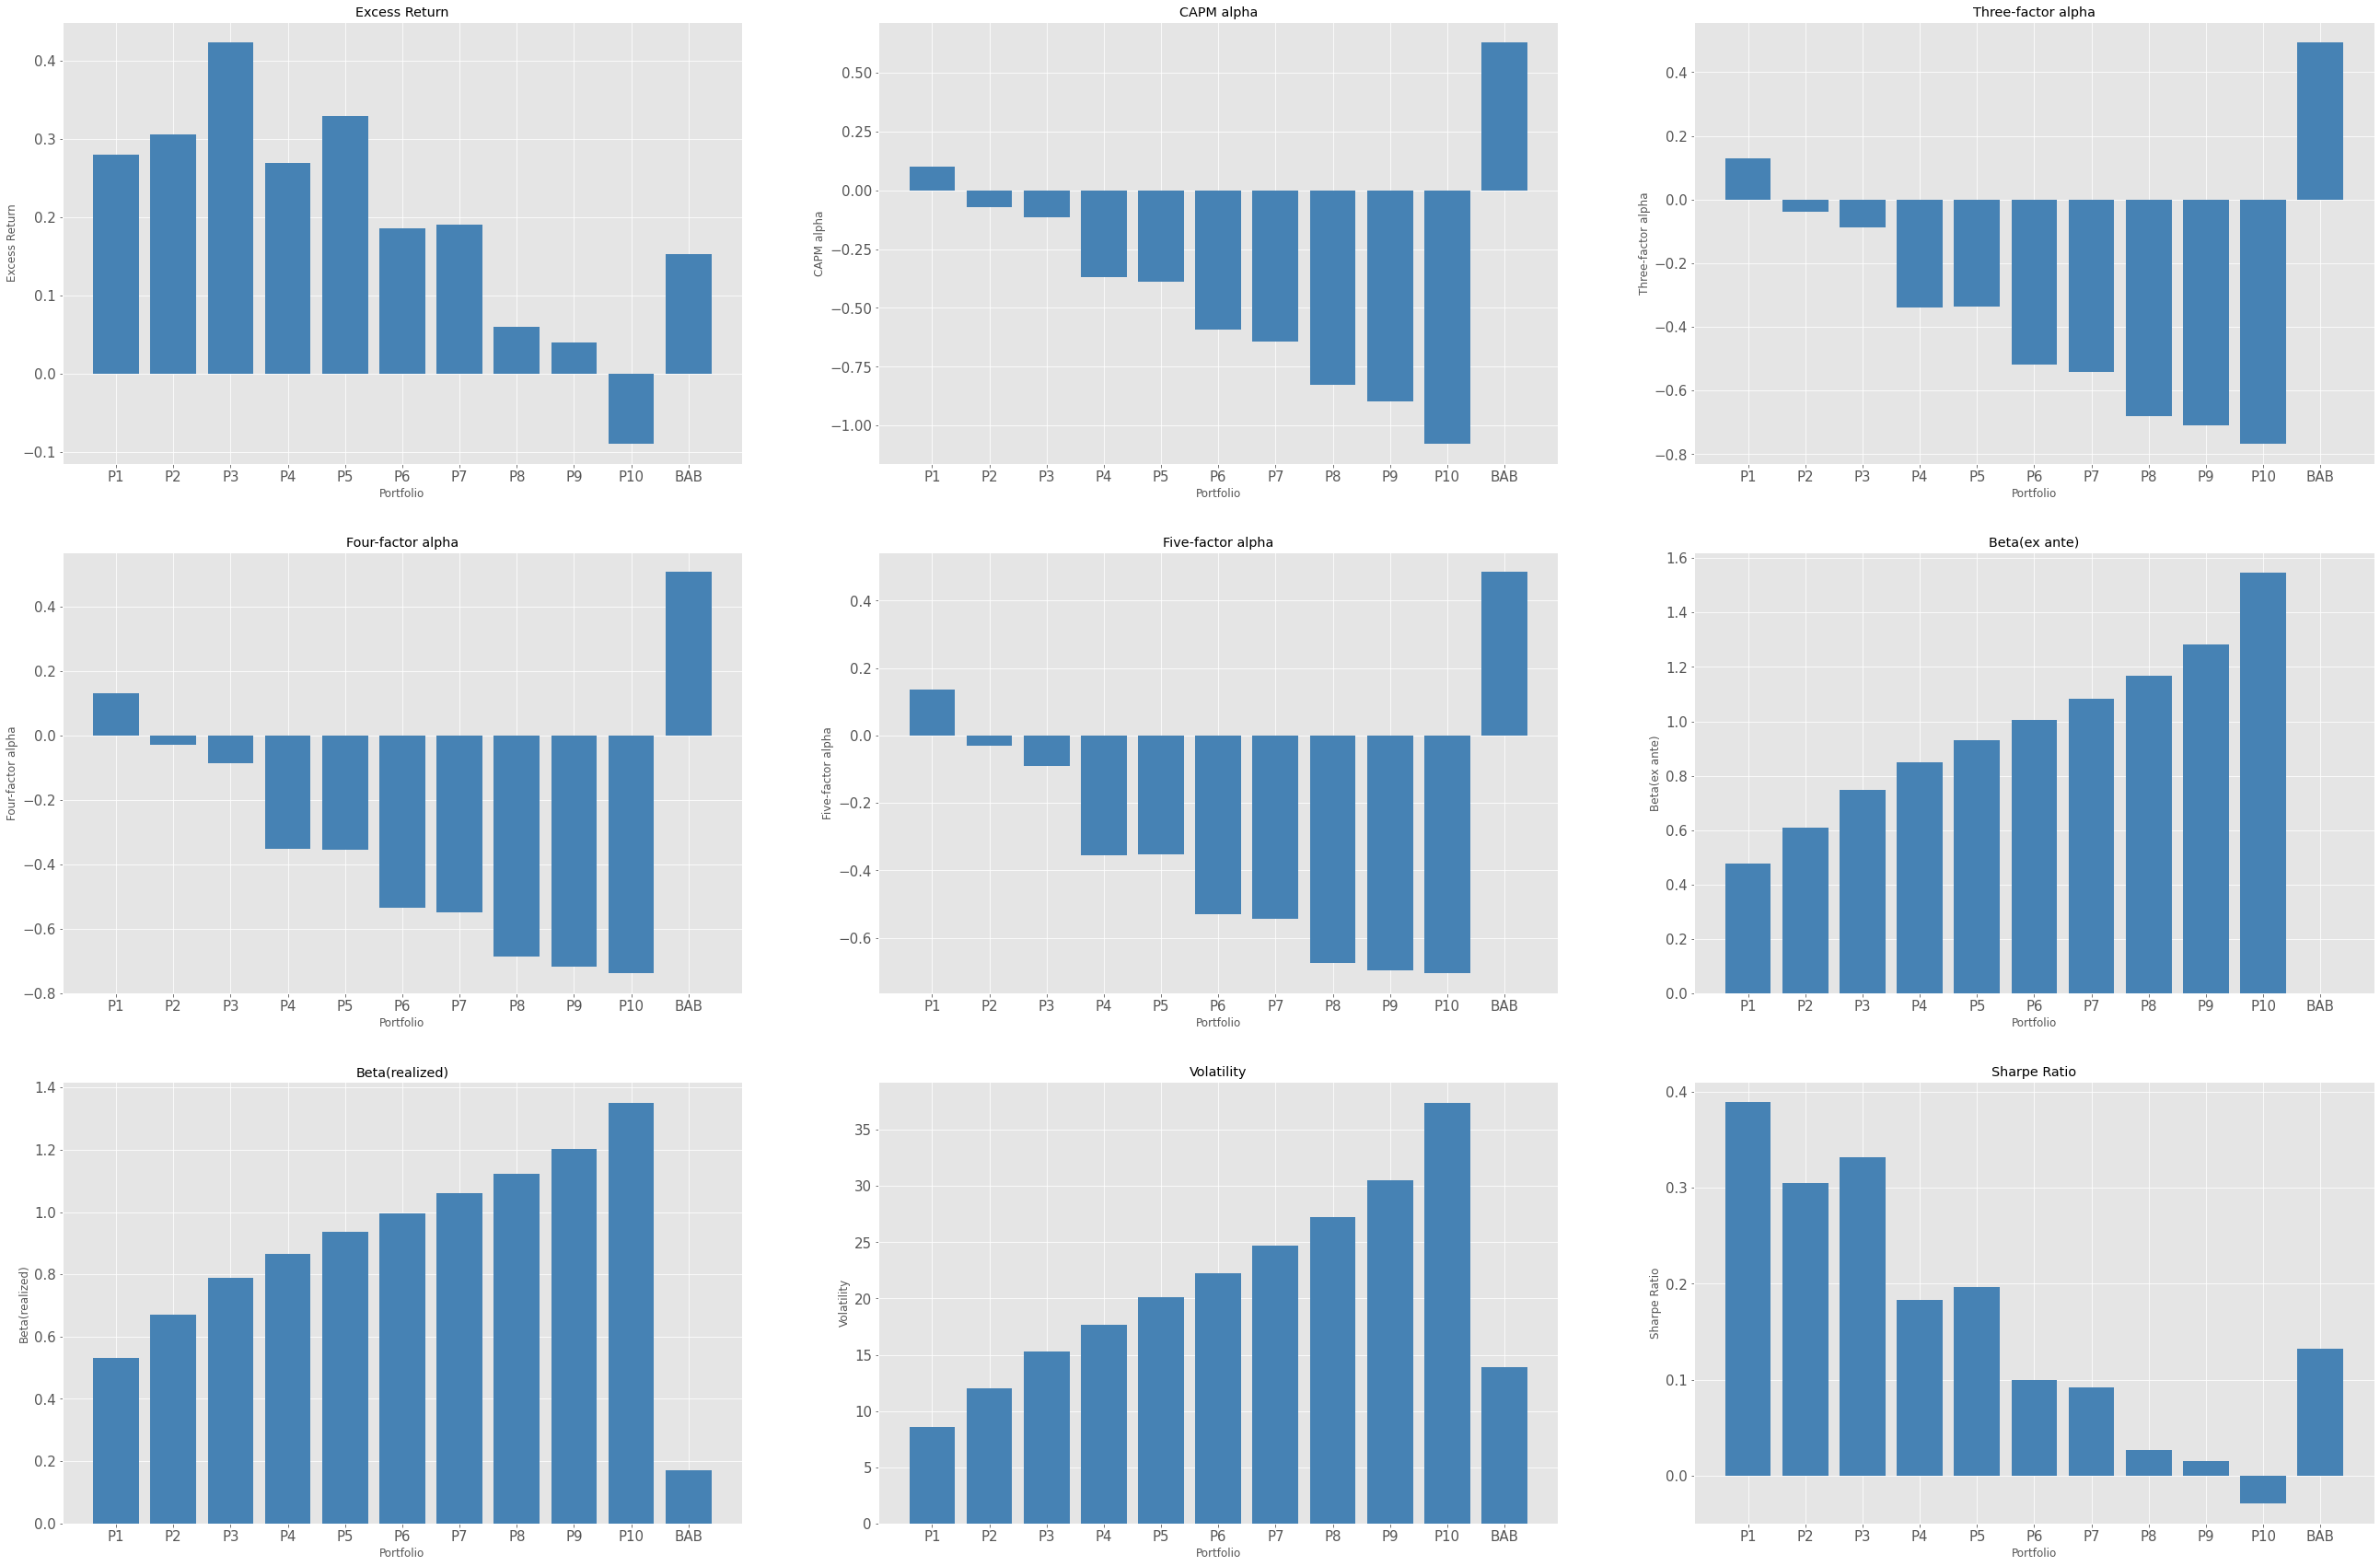

In [37]:
summary_plot(df_table_3)
plt.savefig('../output/US/Graphs/portfolio_summary.jpg', dpi = 200)

### Expansion Phase: 2009-2019

In [38]:
start='2009-01-01'
end = '2019-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [39]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.70395,0.830335,0.997346,0.875525,0.963483,0.828915,0.859253,0.657752,0.634377,0.560508,0.595821
CAPM alpha,0.554516,0.403151,0.291211,0.00237216,-0.0596939,-0.311313,-0.405664,-0.721072,-0.872304,-1.16088,1.30426
Three-factor alpha,0.569358,0.452695,0.346469,0.0730201,0.045982,-0.167212,-0.222451,-0.493991,-0.599904,-0.762467,1.12819
Four-factor alpha,0.569861,0.459836,0.346992,0.0642181,0.0321846,-0.176112,-0.225241,-0.49319,-0.591424,-0.703237,1.11512
Five-factor alpha,0.569271,0.4457,0.326978,0.043448,0.0225646,-0.178387,-0.215927,-0.475437,-0.558847,-0.665343,1.06585
Beta(ex ante),0.475942,0.607021,0.751801,0.858873,0.940224,1.01629,1.09629,1.18624,1.30337,1.57137,0
Beta(realized),0.476316,0.60909,0.746886,0.839186,0.918827,0.989787,1.06304,1.13883,1.22291,1.38603,0.0986232
Volatility,4.88617,7.26426,10.6439,12.9945,15.1168,17.1196,19.2716,21.5692,24.1727,29.8469,11.0815
Sharpe Ratio,1.72884,1.37165,1.12442,0.808521,0.764832,0.581028,0.535039,0.365939,0.314922,0.225353,0.645203


In [40]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,4.65168,3.32745,2.37799,0.0198144,-0.496044,-2.38646,-2.73189,-4.15405,-4.22465,-3.71255,6.60762
Three-factor alpha,4.77517,3.87086,3.03766,0.710528,0.52742,-2.10733,-2.78624,-5.50139,-5.22513,-3.56751,6.57558
Four-factor alpha,4.76962,3.94715,3.03607,0.62379,0.368818,-2.21684,-2.80916,-5.46543,-5.13553,-3.32451,6.50959
Five-factor alpha,4.76132,3.82117,2.87722,0.426006,0.259375,-2.24887,-2.71116,-5.34836,-4.99721,-3.18819,6.36146


### 2009-2020

In [41]:
start='2009-01-01'
end = '2020-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [42]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.669014,0.759165,0.861087,0.759212,0.832459,0.724777,0.72505,0.59697,0.602486,0.490107,0.425794
CAPM alpha,0.426248,0.210296,0.0478816,-0.20863,-0.271621,-0.481677,-0.586037,-0.809726,-0.91406,-1.19276,1.034
Three-factor alpha,0.461267,0.276611,0.124508,-0.114295,-0.128727,-0.295483,-0.349463,-0.506832,-0.536591,-0.627301,0.785884
Four-factor alpha,0.453655,0.271067,0.113758,-0.130333,-0.147261,-0.308225,-0.356592,-0.511678,-0.540236,-0.596845,0.772435
Five-factor alpha,0.457276,0.26687,0.106932,-0.136618,-0.145327,-0.30135,-0.341975,-0.490585,-0.504838,-0.547638,0.734305
Beta(ex ante),0.479763,0.610674,0.751555,0.855937,0.93592,1.01106,1.08989,1.17861,1.29464,1.56122,0
Beta(realized),0.51796,0.661192,0.789274,0.870707,0.942906,1.00342,1.06723,1.13099,1.2085,1.35826,0.167928
Volatility,7.1846,10.4885,13.739,15.9021,18.1039,20.0372,22.2868,24.5928,27.5748,34.0521,12.225
Sharpe Ratio,1.11741,0.86857,0.752096,0.572914,0.551787,0.43406,0.390393,0.29129,0.26219,0.172714,0.417958


In [43]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,2.45466,1.11131,0.268855,-1.28306,-1.64893,-2.81349,-2.96429,-3.61461,-3.35506,-2.96922,3.94239
Three-factor alpha,2.83066,1.60668,0.785916,-0.836776,-1.09678,-2.89975,-3.32459,-4.60986,-3.82863,-2.55452,3.51451
Four-factor alpha,2.73715,1.54513,0.706614,-0.943691,-1.24618,-3.00711,-3.34679,-4.62397,-3.82013,-2.42157,3.41066
Five-factor alpha,2.78086,1.53365,0.668932,-0.99236,-1.2377,-2.96539,-3.25737,-4.54115,-3.703,-2.2709,3.31228


## BAB Factor Comparison

In [44]:
df_AQR_BAB_daily=pd.read_excel('../data/AQR Data/Betting Against Beta Equity Factors Daily.xlsx',\
sheet_name='BAB Factors',header=18,index_col=0,parse_dates=True)
df_AQR_BAB_daily = df_AQR_BAB_daily['2007-12-31':'2020-12-31']

In [45]:
df_BAB_comparison=df_AQR_BAB_daily[['USA']].merge(df_returns[['BAB']],left_index=True,right_index=True)

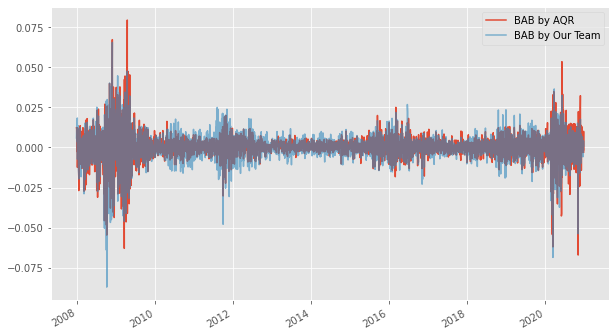

In [46]:
fig, ax =plt.subplots(figsize=(10,6))

df_BAB_comparison['USA'].plot(ax=ax,label='BAB by AQR')
df_BAB_comparison['BAB'].plot(ax=ax,label='BAB by Our Team',alpha=0.6)

plt.legend()

In [47]:
df_BAB_comparison=df_BAB_comparison.rename(columns={'USA':'AQR BAB','BAB':'Our BAB'})

Text(0.5, 1.0, 'BAB Returns Comparison - Scatter')

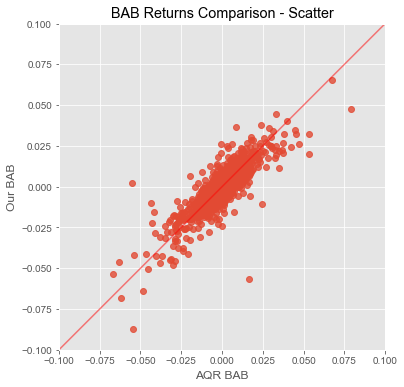

In [48]:
# library & dataset
import seaborn as sns
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, aspect=2)
sns.set_style("whitegrid")

# use the function regplot to make a scatterplot
sns.regplot(x=df_BAB_comparison['AQR BAB'], y=df_BAB_comparison['Our BAB'],ax=ax,fit_reg=False)
#sns.plt.show()
sns.lineplot(x=np.linspace(-0.1,0.1,100), y=np.linspace(-0.1,0.1,100),ax=ax,color='r',alpha=0.5)

ax.set_xlim(-0.10,0.10)
ax.set_ylim(-0.10,0.10)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('BAB Returns Comparison - Scatter')
#plt.savefig('../output/scatter.png',dpi=300)

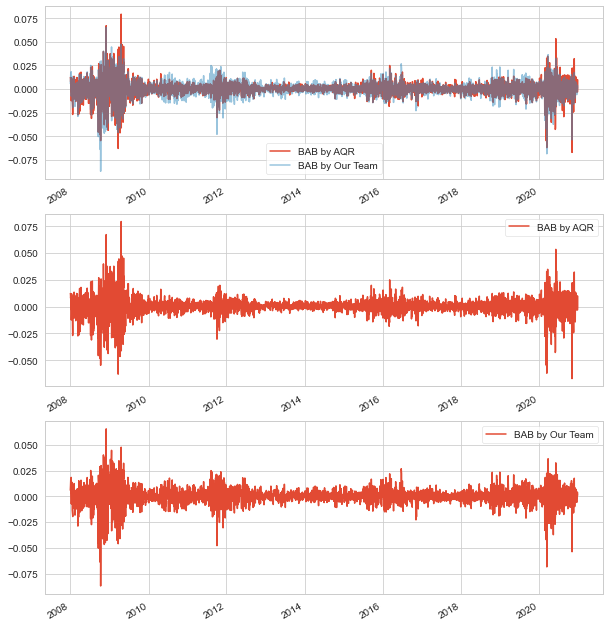

In [49]:
fig, ax =plt.subplots(nrows=3,ncols=1,figsize=(10,12))

df_BAB_comparison['AQR BAB'].plot(ax=ax[0],label='BAB by AQR')
df_BAB_comparison['Our BAB'].plot(ax=ax[0],label='BAB by Our Team',alpha=0.5)
df_BAB_comparison['AQR BAB'].plot(ax=ax[1],label='BAB by AQR')
df_BAB_comparison['Our BAB'].plot(ax=ax[2],label='BAB by Our Team')


ax[0].legend()
ax[1].legend()
ax[2].legend()


# China (validate Bolun)

## Construct the Table 3 and Table 4

In [50]:
df_betas=pd.read_pickle('../output/China/Portfolio Beta and Return Daily/beta.pickle')
df_returns=pd.read_pickle('../output/China/Portfolio Beta and Return Daily/return.pickle')
df_betas = df_betas.astype('float64')
df_returns = df_returns.astype('float64')

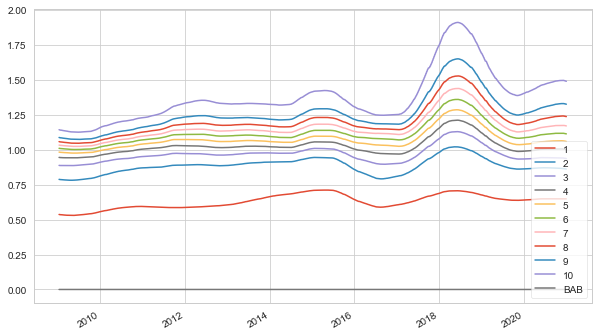

In [51]:
df_betas.rolling(252).mean().plot(figsize=(10,6))

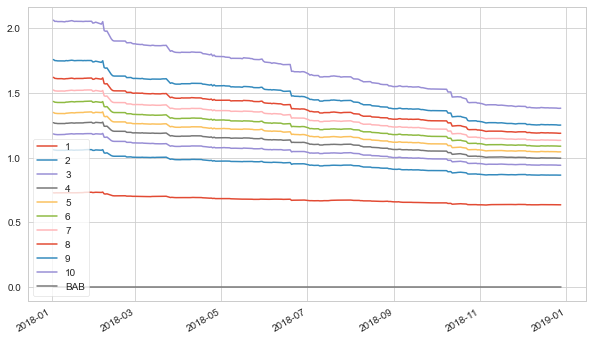

In [52]:
df_betas.loc['2018-01-01':'2018-12-31'].rolling(1).mean().plot(figsize=(10,6)) # Check if extreme beta still exists

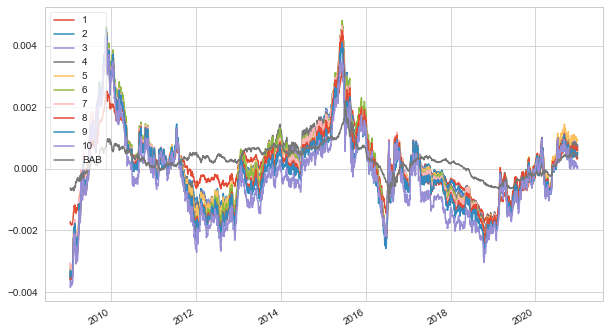

In [53]:
df_returns.rolling(252).mean().plot(figsize=(10,6))

In [54]:
df_FF_5

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2001-01-02,-0.0352,0.0039,0.0165,0.0158,0.0161,0.00026
2001-01-03,0.0539,-0.0065,-0.0439,-0.0266,-0.0594,0.00026
2001-01-04,-0.0130,0.0097,-0.0030,0.0052,-0.0080,0.00026
2001-01-05,-0.0298,0.0071,0.0238,0.0190,0.0231,0.00026
2001-01-08,-0.0036,-0.0043,0.0126,0.0098,0.0067,0.00026
...,...,...,...,...,...,...
2020-12-24,0.0021,-0.0043,-0.0017,0.0024,-0.0005,0.00000
2020-12-28,0.0046,-0.0065,0.0032,0.0146,0.0050,0.00000
2020-12-29,-0.0040,-0.0142,0.0024,0.0075,-0.0028,0.00000


In [55]:
df_returns

,1,2,3,4,5,6,7,8,9,10,BAB
2008-01-02,0.008092,0.028241,0.028046,0.029396,0.032912,0.035669,0.032532,0.029499,0.029555,0.030710,0.000308
2008-01-03,0.008215,0.014111,0.014726,0.020120,0.019895,0.022360,0.022963,0.022232,0.022622,0.024087,-0.003645
2008-01-04,0.004065,0.002442,0.002115,0.001012,0.004271,0.005464,0.001863,0.004410,0.003640,0.003218,0.000450
2008-01-07,0.006384,0.011526,0.011739,0.017699,0.019094,0.021772,0.018297,0.022199,0.016337,0.021196,-0.003612
2008-01-08,-0.001922,-0.017763,-0.022425,-0.024154,-0.026392,-0.025495,-0.025657,-0.029964,-0.029045,-0.029259,0.007069
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,0.006951,0.007801,0.010333,0.012898,0.012028,0.009238,0.006640,0.007978,0.010092,0.003519,0.005509
2020-12-28,-0.006198,-0.011241,-0.010890,-0.008740,-0.007393,-0.009891,-0.009873,-0.006239,-0.011825,-0.016862,-0.001502
2020-12-29,-0.002117,-0.001091,-0.001402,-0.001726,-0.001055,-0.003580,-0.000115,-0.003187,-0.005445,-0.005760,0.001429
2020-12-30,0.001130,0.001608,0.000297,0.002141,0.004408,0.002937,0.004770,0.006635,0.004489,0.003733,-0.001994


In [56]:
df_Port_FF5.corr()

,1,2,3,4,5,6,7,8,9,10,BAB,Mkt-RF,SMB,HML,RMW,CMA,RF
1,1.000000,0.851652,0.742309,0.679854,0.637380,0.609215,0.593137,0.565121,0.555471,0.547978,0.113427,0.535732,0.135853,0.244015,-0.167546,-0.084087,-0.060306
2,0.851652,1.000000,0.942868,0.904555,0.877532,0.855724,0.841099,0.818107,0.805703,0.783897,-0.184085,0.792196,0.293990,0.340709,-0.260586,-0.099745,-0.062389
3,0.742309,0.942868,1.000000,0.974480,0.958758,0.942233,0.930517,0.912584,0.898776,0.870868,-0.360971,0.896796,0.354122,0.359863,-0.279981,-0.106762,-0.052758
4,0.679854,0.904555,0.974480,1.000000,0.984027,0.973967,0.965250,0.951671,0.938401,0.908820,-0.467292,0.934146,0.392442,0.372029,-0.280061,-0.116405,-0.049563
5,0.637380,0.877532,0.958758,0.984027,1.000000,0.988914,0.984352,0.975329,0.965612,0.939301,-0.552893,0.946773,0.428503,0.402192,-0.285050,-0.123338,-0.043942
6,0.609215,0.855724,0.942233,0.973967,0.988914,1.000000,0.990863,0.985645,0.978041,0.953923,-0.603512,0.949403,0.449496,0.422008,-0.294051,-0.121156,-0.041324
7,0.593137,0.841099,0.930517,0.965250,0.984352,0.990863,1.000000,0.991170,0.986322,0.965499,-0.638657,0.945409,0.467298,0.440691,-0.303947,-0.120206,-0.036679
8,0.565121,0.818107,0.912584,0.951671,0.975329,0.985645,0.991170,1.000000,0.991730,0.975143,-0.679433,0.938326,0.484471,0.464702,-0.308685,-0.114923,-0.034077
9,0.555471,0.805703,0.898776,0.938401,0.965612,0.978041,0.986322,0.991730,1.000000,0.984344,-0.705527,0.929472,0.489630,0.479695,-0.308108,-0.120603,-0.030723
10,0.547978,0.783897,0.870868,0.908820,0.939301,0.953923,0.965499,0.975143,0.984344,1.000000,-0.731096,0.899577,0.489761,0.514424,-0.324894,-0.107407,-0.028133


In [57]:
df_Port_FF5=df_returns.merge(df_FF_5,left_index=True,right_index=True)
df_Port_FF5 = df_Port_FF5.dropna()

In [58]:
df_Port_FF5.index

DatetimeIndex(['2008-01-02', '2008-01-03', '2008-01-04', '2008-01-07',
               '2008-01-08', '2008-01-09', '2008-01-10', '2008-01-11',
               '2008-01-14', '2008-01-15',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=3035, freq=None)

### All data: 2008-2020

In [59]:
start='2008-01-01'
end = '2020-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [60]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.0256087,-0.329759,-0.319588,-0.325691,-0.332714,-0.424444,-0.604813,-0.78015,-0.993541,-1.53883,0.433502
CAPM alpha,0.052792,-0.192101,-0.113868,-0.0768927,-0.0370315,-0.0998425,-0.282771,-0.460777,-0.672642,-1.30469,0.475452
Three-factor alpha,0.0307596,-0.238931,-0.17265,-0.13823,-0.101588,-0.168529,-0.349218,-0.537897,-0.746725,-1.39092,0.488448
Four-factor alpha,0.0407879,-0.214177,-0.15381,-0.118298,-0.0816833,-0.149768,-0.331567,-0.516561,-0.724721,-1.37129,0.495281
Five-factor alpha,0.048104,-0.2057,-0.147356,-0.113262,-0.0744809,-0.143523,-0.324471,-0.510129,-0.718269,-1.36214,0.498952
Beta(ex ante),0.626495,0.87847,0.961728,1.01986,1.06706,1.10947,1.15066,1.19565,1.25331,1.369,0
Beta(realized),0.433681,0.459001,0.463618,0.471942,0.471027,0.471676,0.476154,0.480073,0.481803,0.488368,0.3983
Volatility,13.3076,23.8432,27.141,29.3896,31.104,32.4743,33.3288,34.2839,35.6022,37.2,8.29324
Sharpe Ratio,0.0230924,-0.165963,-0.141301,-0.132982,-0.128362,-0.156842,-0.217762,-0.273067,-0.33488,-0.496398,0.627261


In [61]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,0.157894,-0.320256,-0.166627,-0.103954,-0.0472639,-0.122099,-0.337019,-0.534091,-0.750914,-1.3946,2.27572
Three-factor alpha,0.091977,-0.398354,-0.252663,-0.186858,-0.129654,-0.206173,-0.416185,-0.623595,-0.833808,-1.48703,2.34265
Four-factor alpha,0.122122,-0.357275,-0.225405,-0.160119,-0.104423,-0.183596,-0.39582,-0.599966,-0.810834,-1.46867,2.38398
Five-factor alpha,0.14401,-0.342819,-0.215769,-0.15317,-0.0951426,-0.175804,-0.3871,-0.592007,-0.803065,-1.45806,2.4001


### Expansion Phrase: 2009-2019

In [62]:
start='2009-01-01'
end = '2019-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [63]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.408386,0.408955,0.402824,0.422659,0.369237,0.349059,0.0667075,-0.103756,-0.346551,-0.900461,0.603538
CAPM alpha,0.403253,0.45802,0.487942,0.528079,0.512064,0.520989,0.246645,0.0767319,-0.152999,-0.742756,0.656604
Three-factor alpha,0.387672,0.42844,0.452446,0.492554,0.472897,0.476702,0.203659,0.0269801,-0.202493,-0.794951,0.662644
Four-factor alpha,0.384159,0.421525,0.440076,0.479211,0.460987,0.462374,0.184415,0.0154996,-0.216337,-0.811474,0.666836
Five-factor alpha,0.402179,0.445953,0.462544,0.505406,0.491971,0.495772,0.218334,0.0504664,-0.184665,-0.771333,0.665702
Beta(ex ante),0.632986,0.888533,0.970966,1.02866,1.07574,1.11851,1.16003,1.20498,1.26252,1.37969,0
Beta(realized),0.445078,0.490161,0.498987,0.511874,0.512635,0.516815,0.521753,0.528325,0.530991,0.535377,0.389433
Volatility,13.1283,22.3104,24.8951,26.9077,28.4987,29.9353,30.8204,31.6401,32.9328,34.4856,7.54901
Sharpe Ratio,0.373286,0.219963,0.19417,0.188493,0.155475,0.139925,0.0259728,-0.0393511,-0.126276,-0.313335,0.959392


In [64]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,1.11876,0.747082,0.712737,0.713711,0.653029,0.63308,0.291299,0.0883479,-0.169345,-0.785663,3.17754
Three-factor alpha,1.07416,0.698407,0.660476,0.665601,0.602974,0.579242,0.240483,0.0310642,-0.224166,-0.840672,3.21484
Four-factor alpha,1.06452,0.685643,0.641461,0.646501,0.586899,0.561236,0.217513,0.0178273,-0.239264,-0.857269,3.2392
Five-factor alpha,1.11428,0.72494,0.673747,0.681193,0.625719,0.601411,0.257407,0.0579992,-0.204115,-0.814692,3.22494


### 2009-2020

In [65]:
start='2009-01-01'
end = '2020-12-31'
df_table_3,df_table_4 = get_table_3_4(df_Port_FF5[start:end],df_betas[start:end])

In [66]:
df_table_3

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
Excess Return,0.389806,0.416791,0.440003,0.451369,0.433951,0.341472,0.0924243,-0.0498097,-0.314642,-0.898342,0.608242
CAPM alpha,0.375981,0.461965,0.520403,0.551127,0.568586,0.50647,0.269471,0.130079,-0.12317,-0.749329,0.650436
Three-factor alpha,0.358424,0.432443,0.485574,0.519891,0.532263,0.466479,0.230587,0.0809013,-0.169146,-0.806681,0.656225
Four-factor alpha,0.359633,0.435682,0.485368,0.52189,0.533572,0.466659,0.231292,0.0858448,-0.165744,-0.803748,0.656392
Five-factor alpha,0.371239,0.45315,0.502457,0.541008,0.556138,0.49118,0.25601,0.112055,-0.140917,-0.773481,0.653969
Beta(ex ante),0.634148,0.886205,0.968056,1.02626,1.07425,1.11793,1.16069,1.2074,1.26742,1.38823,0
Beta(realized),0.448364,0.488011,0.495681,0.507893,0.509099,0.511727,0.514898,0.521791,0.525533,0.532982,0.394556
Volatility,13.0917,22.0543,24.5369,26.4981,28.0448,29.4383,30.324,31.1944,32.5403,34.1876,7.44462
Sharpe Ratio,0.357302,0.226781,0.215188,0.204408,0.185682,0.139195,0.0365748,-0.019161,-0.116031,-0.315322,0.980427


In [67]:
df_table_4

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,BAB
CAPM alpha,1.09546,0.798549,0.8079,0.792465,0.771971,0.65539,0.338643,0.159044,-0.144416,-0.836956,3.32602
Three-factor alpha,1.04305,0.74719,0.753186,0.747301,0.722356,0.603467,0.289606,0.0988688,-0.198234,-0.900178,3.36208
Four-factor alpha,1.04766,0.752675,0.753108,0.750379,0.724428,0.604116,0.290639,0.104974,-0.194363,-0.89731,3.36568
Five-factor alpha,1.08186,0.782896,0.779574,0.777656,0.7549,0.635892,0.321731,0.137003,-0.165244,-0.863746,3.34685
